In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
from itertools import product, cycle
from heapq import heapify, heappush, heappop
import h5py as hf
import cv2
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset
import networkx as nx

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.collections import PatchCollection
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.data import InterventionSamplerBase
from omnilearn import viz as viz_util

from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from src import sample_full_interventions, response_mat, factor_reponses
from src.responses import sample_full_interventions

# import gpumap
from c3linearize import linearize, class_graph

fig.get_config().silence();

In [2]:
device = 'cuda'
# device = 'cuda:1'
dataset = None
figure_root = Path('figures/responses')
figure_root = None
if figure_root is not None and not figure_root.exists():
    figure_root.mkdir()
seed = 10
B = 128
N = 16
G = 32

In [3]:
root = Path(r'C:/Users/anwan/Documents/workspace/lat_resp_models/')
# root = Path(r'C:/Users/anwan/Documents/workspace/exts/')
run_names = os.listdir(str(root))
len(run_names)

57

In [4]:
# print(tabulate(enumerate(run_names)))

In [5]:
dsname = 'celeba'
model_names = '''VAE1	celeba_vae1_e-c12_d-c12_d64-s2_210521-013413
VAE2	celeba_vae2_e-c12_d-c12_d64_210521-013413
VAE4	celeba_vae4_e-c12_d-c12_d64_210521-013413
VAE8	celeba_vae8_e-c12_d-c12_d64_210521-051200
VAE12	celeba_vae12_e-c12_d-c12_d64_210521-051200'''.split('\n')
model_names = [row.split('\t') for row in model_names]

if dataset is None:
    dataset = fig.quick_run('load-data', name='celeba', labeled=True, label_type='attr', shuffle=False, seed=seed)

In [4]:
dsname = 'toy'
dsname = 'real'
model_names = '''VAE1-6	toy_vae1_e-c12_d-c12_d6-ch128-strd-trans_210522-020221	real_vae1_e-c12_d-c12_d6-ch128-strd-trans_210522-020221
VAE1-8	toy_vae1_e-c12_d-c12_d8-ch128-strd-trans_210522-020221	real_vae1_e-c12_d-c12_d8-ch128-strd-trans_210522-020222
VAE1-10	toy_vae1_e-c12_d-c12_d10-ch128-strd-trans_210522-020222	real_vae1_e-c12_d-c12_d10-ch128-strd-trans_210522-020221
VAE1-12	toy_vae1_e-c12_d-c12_ch128-strd-trans_210522-015012	real_vae1_e-c12_d-c12_d12-ch128-strd-trans_210522-020222
VAE1-16	toy_vae1_e-c12_d-c12_d16-ch128-strd-trans_210522-020223	real_vae1_e-c12_d-c12_d16-ch128-strd-trans_210522-020222
VAE1-32	toy_vae1_e-c12_d-c12_d32-ch128-strd-trans_210522-020222	real_vae1_e-c12_d-c12_d32-ch128-strd-trans_210522-020221'''.split('\n')
model_names = [row.split('\t') for row in model_names]
if dsname == 'real':
    model_names = [[row[0], row[-1]] for row in model_names]
else:
    model_names = [[row[0], row[1]] for row in model_names]
    dsname = 'toy'

if dataset is None:
    dataset = fig.quick_run('load-data', name='mpi3d', category=dsname, mode='train', labeled=True, shuffle=False, sort=True, seed=seed)
#     dataset = fig.quick_run('load-data', name='mpi3d', category=dsname, mode='full', labeled=True, shuffle=False, sort=True, seed=seed)

In [4]:
dsname = 'mnist'
# dsname = 'fmnist'
model_names = '''VAE1	mnist_vae1_d-conv_210517-010809	mnist_vae1_d-conv_fashion_210517-111436
VAE1-s2	mnist_vae1_d-conv_s2_210523-154655	mnist_vae1_d-conv_fashion-s2_210523-154656
VAE1-s3	mnist_vae1_d-conv_s3_210523-154656	mnist_vae1_d-conv_fashion-s3_210523-154656
VAE2	mnist_vae2_d-conv_210517-010809	mnist_vae2_d-conv_fashion_210517-111436
VAE2-s2	mnist_vae2_d-conv_s2_210523-154655	mnist_vae2_d-conv_fashion-s2_210523-154656
VAE2-s3	mnist_vae2_d-conv_s3_210523-154656	mnist_vae2_d-conv_fashion-s3_210523-154656
VAE4	mnist_vae4_d-conv_210517-011708	mnist_vae4_d-conv_fashion_210523-154656
VAE4-s2	mnist_vae4_d-conv_s2_210523-154656	mnist_vae4_d-conv_fashion-s2_210523-154656
VAE4-s3	mnist_vae4_d-conv_s3_210523-154656	mnist_vae4_d-conv_fashion-s3_210523-154655
VAE8	mnist_vae8_d-conv_210517-011730	mnist_vae8_d-conv_fashion_210523-154656
VAE8-s2	mnist_vae8_d-conv_s2_210523-154657	mnist_vae8_d-conv_fashion-s2_210523-154656
VAE8-s3	mnist_vae8_d-conv_s3_210523-154658	mnist_vae8_d-conv_fashion-s3_210523-154656'''.split('\n')
model_names = [row.split('\t') for row in model_names]
if dsname == 'fmnist':
    model_names = [[row[0], row[-1]] for row in model_names]
else:
    model_names = [[row[0], row[1]] for row in model_names]
    dsname = 'mnist'
    
if dataset is None:
    dataset = fig.quick_run('load-data', name=dsname, mode='full', labeled=True, shuffle=False, seed=seed)

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


In [5]:
dsname = '3ds12'
# dsname = '3ds24'
model_names = '''VAE1	3ds_vae1_d-conv_s1_210523-164722	3ds_vae1_d-conv_d24-s1_210523-164723
VAE1-s2	3ds_vae1_d-conv_s2_210523-164723	3ds_vae1_d-conv_d24-s2_210523-164722
VAE2	3ds_vae2_d-conv_s1_210523-164723	3ds_vae2_d-conv_d24-s1_210523-164722
VAE2-s2	3ds_vae2_d-conv_s2_210523-164722	3ds_vae2_d-conv_d24-s2_210523-164722
VAE4	3ds_vae4_d-conv_s1_210523-164723	3ds_vae4_d-conv_d24-s1_210523-164722
VAE4-s2	3ds_vae4_d-conv_s2_210523-164722	3ds_vae4_d-conv_d24-s2_210523-164722
VAE8	3ds_vae8_d-conv_s1_210523-164722	3ds_vae8_d-conv_d24-s1_210523-164723
VAE8-s2	3ds_vae8_d-conv_s2_210523-164722	3ds_vae8_d-conv_d24-s2_210523-164722'''.split('\n')
model_names = [row.split('\t') for row in model_names]
if dsname == '3ds24':
    model_names = [[row[0], row[-1]] for row in model_names]
else:
    model_names = [[row[0], row[1]] for row in model_names]
    dsname = '3ds12'

if dataset is None:
    dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False, seed=seed)

In [5]:
batch = dataset.get_batch(shuffle=True)
X, Y = batch
X.shape, Y.shape

(torch.Size([64, 1, 32, 32]), torch.Size([64]))

In [6]:
# util.plot_imgs(X);

In [7]:
sampler, interventions = None, None
if dsname in {'3ds12', '3ds24', 'toy', 'real'}:
    factors = dataset.get_factor_order()
    factor_sizes = dataset.get_factor_sizes()
    print(factors, factor_sizes)
    sampler = InterventionSamplerBase(dataset)
    interventions = sample_full_interventions(sampler, num_groups=20, pbar=tqdm)
    intervention_dim = 0
    intervention_imgs = sampler.full_intervention(intervention_dim)
    imgs = intervention_imgs
    util.plot_imgs(imgs);

In [8]:
runs = [fig.quick_run('load-run', path=row[-1], root=str(root), **{'override.device':'cpu'}) for row in model_names]

ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"
ERROR:omnifig.organization: Could not find mod "cls-run" for component "sae-run"


In [9]:
print(tabulate([[i,*row] for i,row in enumerate(model_names)], headers=['Idx', 'Model', 'Run']))

  Idx  Model    Run
-----  -------  ----------------------------------
    0  VAE1     mnist_vae1_d-conv_210517-010809
    1  VAE1-s2  mnist_vae1_d-conv_s2_210523-154655
    2  VAE1-s3  mnist_vae1_d-conv_s3_210523-154656
    3  VAE2     mnist_vae2_d-conv_210517-010809
    4  VAE2-s2  mnist_vae2_d-conv_s2_210523-154655
    5  VAE2-s3  mnist_vae2_d-conv_s3_210523-154656
    6  VAE4     mnist_vae4_d-conv_210517-011708
    7  VAE4-s2  mnist_vae4_d-conv_s2_210523-154656
    8  VAE4-s3  mnist_vae4_d-conv_s3_210523-154656
    9  VAE8     mnist_vae8_d-conv_210517-011730
   10  VAE8-s2  mnist_vae8_d-conv_s2_210523-154657
   11  VAE8-s3  mnist_vae8_d-conv_s3_210523-154658


In [10]:
run = runs[4]
run

INLINE_TIMED_SAE_RUN:mnist_vae2_d-conv_s2_210523-154655

In [11]:
A = run.get_config()
info = A.pull('info')
info

{'dataset_type': 'mnist',
 'dec_type': 'conv',
 'extra': 's2',
 'model_type': 'vae',
 'size': 32}

In [12]:
if figure_root is not None:
    figure_dir = figure_root / run_name
    if not figure_dir.exists():
        figure_dir.mkdir()
else:
    figure_dir = None
model = run.get_model()
model.switch_to('val')
model.to(device);
def ae_cycle(q):
    im = model.decode(q.to(device))
    q = model.encode(im)
    if isinstance(q, distrib.Normal):
        q = q.loc
    return im.cpu(), q.cpu()
@torch.no_grad()
def response_function(q):
    q = q.to(device)
    r = model.encode(model.decode(q))
    if isinstance(r, distrib.Normal):
        r = r.loc
    return r#.sub(q).cpu()
@torch.no_grad()
def intervention_response_function(q, dq):
    rq = model.encode(model.decode(q.to(device)))
    if isinstance(rq, distrib.Normal):
        rq = rq.loc
    rdq = model.encode(model.decode(q.add(dq).to(device)))
    if isinstance(rdq, distrib.Normal):
        rdq = rdq.loc
    return rdq.sub(rq).cpu()
    
def encode(x):
    with torch.no_grad():
        q = model.encode(x.to(device))
        if isinstance(q, distrib.Normal):
            q = q.loc
    return q
def decode(q):
    with torch.no_grad():
        return model.decode(q.to(device))

Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): C

In [13]:
figure_dir

In [14]:
stretch = 0.1
pt_num = 200

In [15]:
Qdis = None
with torch.no_grad():
    Q = model.encode(X.to(device))
    if isinstance(Q, distrib.Normal):
        Qdis = Q
        Q = Q.mean
    Q = Q.cpu()

rg = Q.max(0)[0] - Q.min(0)[0]
rg = rg.unsqueeze(-1)
mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
Q.shape

torch.Size([64, 12])

In [16]:
# util.plot_imgs(X[:16]);
# util.plot_imgs(decode(Q[:16]));

In [17]:
bidx = 0

q = Q[bidx]
Q.shape, q.shape

(torch.Size([64, 12]), torch.Size([12]))

In [18]:
fullQ = []
total = 10000 if dsname != 'celeba' else 1000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ).cpu()
D = fullQ.size(-1)
fullQ.shape

  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 12])

In [19]:
scales = fullQ.std(0)
# scales = None

In [20]:
# C = np.cov(fullQ.div(scales).cpu().t().numpy())
# # util.plot_mat(C, cmap='seismic', vmin=-1, vmax=1)
# util.plot_mat(C, 
# #               val_fmt=2, 
#               cmap='seismic', vmin=-1, vmax=1)
# plt.tight_layout()
# # util.save_figure(f'{run_name}_cov', root=figure_dir)
# util.save_figure(f'cov', root=figure_dir)

In [21]:
N = 100

# Rold = response_mat(fullQ[:N].to(device), model.encode, model.decode, scales=scales.to(device), dist_type='rms', force_different=True).cpu()

def new_response_mat(Q, n_interv=64, max_batch_size=None):
    if max_batch_size is None:
        max_batch_size = n_interv
    
    B, D = Q.shape
    
    resps = []
    for i, qi in enumerate(Q.t()):
        qsel = torch.randint(B, size=(n_interv,))
        isel = torch.randint(B, size=(n_interv,))
        q = Q[qsel]
        dq = q.clone()
        dq[:,i] = qi[isel]
        z = util.process_in_batches(response_function, q, batch_size=max_batch_size)
        dz = util.process_in_batches(response_function, dq, batch_size=max_batch_size)
        resps.append(dz.sub(z).pow(2).mean(0).sqrt())
    return torch.stack(resps)

R = new_response_mat(fullQ, n_interv=256, max_batch_size=64)
R.shape

torch.Size([12, 12])

In [22]:
threshold = 0.5
threshold_2d = 0.1

In [23]:
sel = torch.arange(len(R))[R.diag() > threshold]
bsel = torch.arange(len(R))[R.diag() <= threshold]
sel, bsel

(tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11]), tensor([0, 4]))

<IPython.core.display.Javascript object>


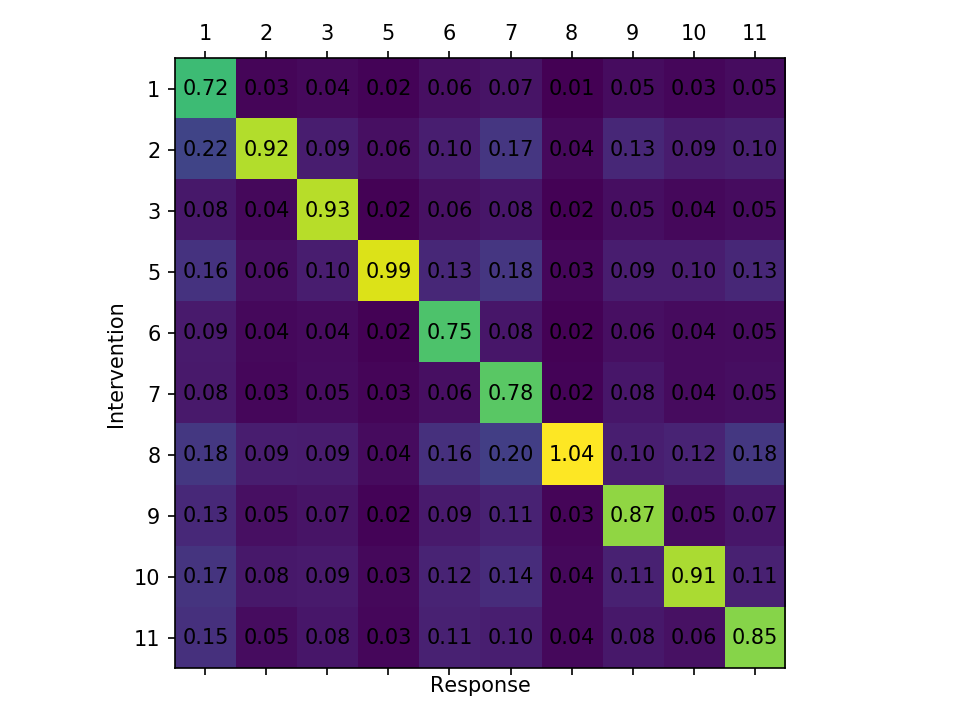

In [24]:
Rsel = R[sel][:,sel]
hside = 0.4
util.plot_mat(Rsel, val_fmt=2,
#               figsize=(len(Rsel)*hside, hside*len(Rsel))
             ) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
plt.tight_layout()
# util.save_figure(f'{run_name}_sel_responses', root=figure_dir)
# util.save_figure(f'sel_responses', root=figure_dir)

In [25]:
# G = nx.from_numpy_matrix(R[sel][:,sel].cpu().pow(1.).numpy(), create_using=nx.MultiDiGraph)

# colors = 'C2'
# # colors = ['C2' if i in sel else 'C3' for i in range(len(G))]

# edges,weights = zip(*sorted(nx.get_edge_attributes(G,'weight').items(), key=lambda x: x[-1], reverse=False))

# try:
#     pos = nx.planar_layout(G)
# except:
# #     pos = nx.spring_layout(G)
#     pos = nx.circular_layout(G)

# kwargs = dict(pos=pos, node_color=colors, labels={i:str(n.item()) for i,n in enumerate(sel)},#, with_labels=True,
#               edgelist=edges, edge_color=weights,
#               edge_cmap=plt.get_cmap('binary'), vmin=0)
# plt.figure()
# nx.draw(G, **kwargs)
# # util.save_figure(f'{run_name}_graph', root=figure_dir)
# # util.save_figure(f'sel-graph', root=figure_dir)

In [29]:
resp = R.cpu()[sel][:,sel]
D = resp.size(-1)
resp.shape

torch.Size([10, 10])

In [30]:
scores = resp + resp.t()
scores -= scores.diag().diag()
relscores = scores.div(scores.sum(-1,keepdim=True))
# util.plot_mat(relscores, val_fmt=2);
# plt.xticks(np.arange(len(sel)), map(str,sel.tolist()))
# plt.yticks(np.arange(len(sel)), map(str,sel.tolist()))
# plt.tight_layout();

In [31]:
def collect_pairs(scores, inds, temp=1.):
    while len(inds) >= 2:
        pick = torch.stack(torch.meshgrid(torch.arange(len(inds)),torch.arange(len(inds)),),-1).reshape(-1,2).tolist()[np.random.choice(np.arange(len(inds)**2), p=F.normalize(scores.reshape(-1).pow(1/temp),p=1,dim=0).numpy())]
        yield (inds[pick].tolist(), scores[tuple(pick)].item())
        sel = torch.ones(len(inds)).bool()
        sel[pick] = 0
        scores, inds = scores[sel][:,sel], inds[sel]
    if len(inds):
        yield inds.item()
    else:
        yield None
    yield None
*picks, remainder, _ = list(collect_pairs(scores.clone(), sel.clone(), temp=0.2))
pairs, sc_picks = zip(*picks)
print(remainder, pairs, sc_picks)

None ([6, 8], [1, 2], [9, 7], [10, 5], [3, 11]) (0.17425215244293213, 0.2511427700519562, 0.18962275981903076, 0.1305738091468811, 0.1237223744392395)


In [32]:
bidx = np.random.randint(len(Q))
bidx

34

In [33]:
dims = pairs[np.random.choice(len(pairs))]
# dims = pairs[0]

dims, sc = next(iter(collect_pairs(relscores.clone(), sel.clone(), temp=0.2)))

dims = 8, 5

ix, iy = dims
dims = list(dims)

Qsel = Q[:,dims]
pt = Qsel.sub(Qsel.mean(0,keepdim=True))
# plt.figure()
# plt.scatter(*pts.t(), marker='.', c='k');
U, S, V = torch.svd(pt.t() @ pt / (len(pt) - 1))
S = S.sqrt()
# print('S',S)
# print(U)

# vec = fullQ[N:N+pt_num].detach().cpu()
# pts = vec[:,dims]
# mu = pts.mean(0)
# pt = pts.sub(pts.mean(0,keepdim=True))
# U, S, V = torch.svd(pt.t() @ pt / (B - 1))
# S = S.sqrt()
# # plt.figure()
# # plt.scatter(*pts.t(), marker='.', c='k');
# # plt.axis('equal');
# # plt.grid(b=True, which='both', color='0.65', linestyle='--')
# # ars = torch.stack([mu, mu+S[0]*U[0]])
# # plt.plot(*ars.t());
# # ars = torch.stack([mu, mu+S[1]*U[1]])
# # plt.plot(*ars.t());
# se2 = util.aff_invert(util.se2_tfm(U, mu.unsqueeze(1)))
# fixed = util.aff_transform(pts, se2)
# # plt.scatter(*fixed.t(), marker='x', c='r');

dims, sc

([8, 5], 0.12427327781915665)

In [37]:
stretch = .2
rg = 5

mn, mx = Q.min(0)[0].unsqueeze(-1)-stretch*rg, Q.max(0)[0].unsqueeze(-1)+stretch*rg
mn, mx = mn.view(-1), mx.view(-1)

print(mn[list(dims)], mx[list(dims)])

mn, mx = torch.ones(len(mn))*-rg, torch.ones(len(mx))*rg

tensor([-2.6021, -2.3227]) tensor([2.6603, 2.8034])


In [38]:
n = 100
h, w = n, n

n_base = 12
base_inds = torch.randint(len(Q),size=(n_base,)).tolist()
base_inds = [bidx]

xvals, yvals = torch.linspace(mn[ix].item(),mx[ix].item(),h), torch.linspace(mn[iy].item(),mx[iy].item(),w)
# xvals, yvals = torch.linspace(-rg,rg,h), torch.linspace(-rg,rg,w)
cx, cy = torch.meshgrid(xvals, yvals)
cx = cx.reshape(-1)
cy = cy.reshape(-1)

gradmap = None
for idx in base_inds:
    vecs = Q[idx:idx+1].expand(len(cx), -1).contiguous()
    vecs[:, ix] = cx
    vecs[:, iy] = cy

    starts = vecs[...,dims]
    ends = []
    for v, in tqdm(DataLoader(TensorDataset(vecs), batch_size=100), desc=f'Cycling {len(vecs)} samples'):
        with torch.no_grad():
            ends.append(ae_cycle(v)[1][...,dims])
    starts = starts.view(h,w,2)
    ends = torch.cat(ends).view(h,w,2)
    if gradmap is None:
        gradmap = ends.sub(starts)
    else:
        gradmap += ends.sub(starts)
gradmap /= len(base_inds)

def get_divergence(vmap):
    divx, divy = np.gradient(vmap, axis=[0,1])
    divM = divx[...,0] + divy[...,1]
    return torch.from_numpy(divM)

magmap = gradmap.norm(dim=-1)
divmap = get_divergence(gradmap)
sdivmap = divmap.clone()
if sdivmap.min() < 0:
    sdivmap[sdivmap<0] /= sdivmap.min().abs()
else:
    print('WARNING: min')
if sdivmap.max() > 0:
    sdivmap[sdivmap>0] /= sdivmap.max().abs()
else:
    print('WARNING: max')

curvmap = -0.5*get_divergence(gradmap.div(magmap.unsqueeze(-1)))
happymap = divmap<0

gradmap.shape, divmap.max(), divmap.min()

Cycling 10000 samples:   0%|          | 0/100 [00:00<?, ?it/s]

(torch.Size([100, 100, 2]), tensor(0.0312), tensor(-0.1916))

<IPython.core.display.Javascript object>


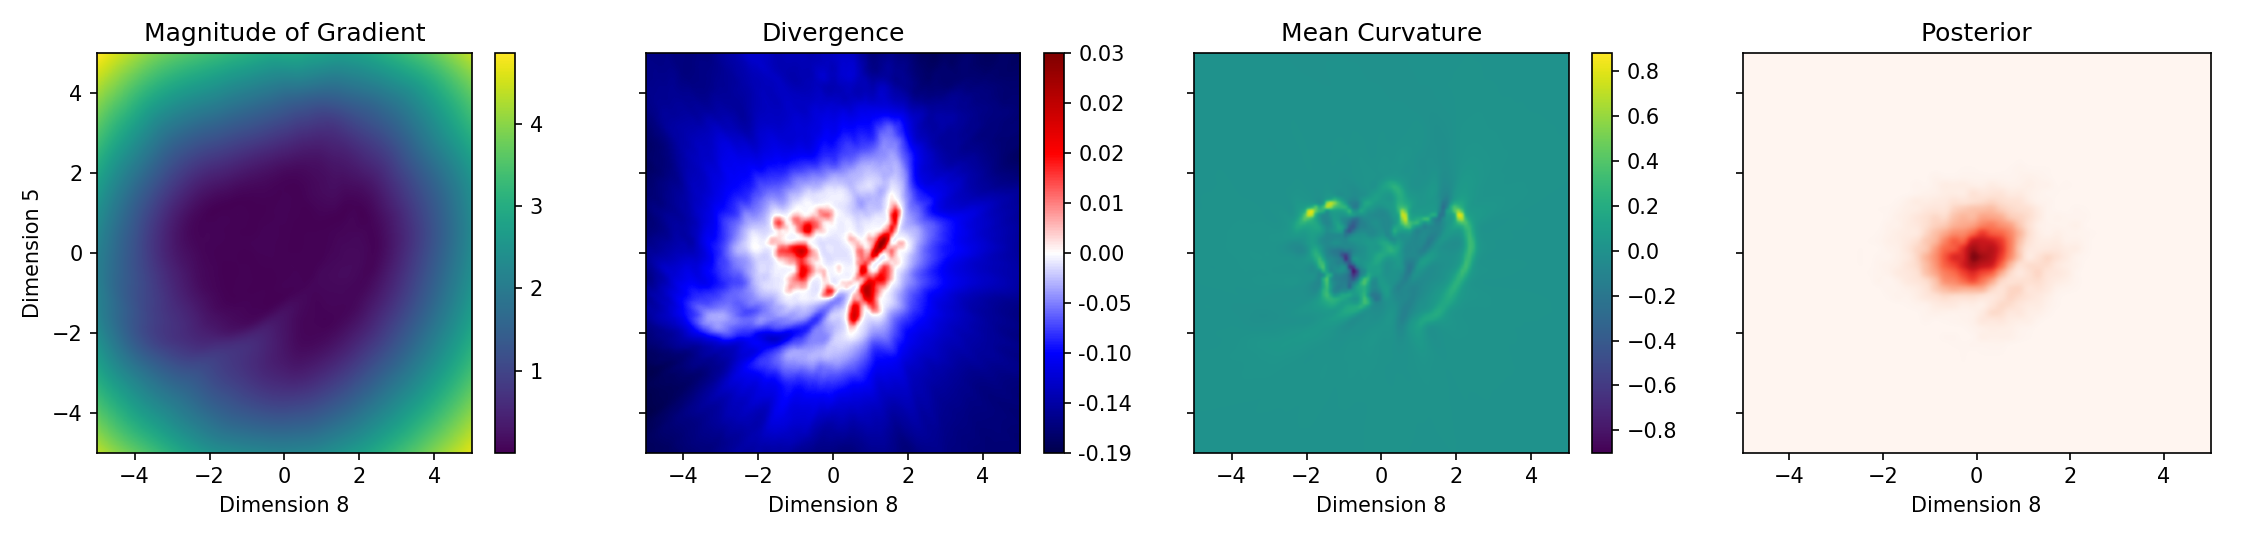

In [39]:
im_kwargs = dict(
    aspect = 'auto',
    extent=[xvals.min(),xvals.max(),yvals.min(),yvals.max()],
)

fg, axs = plt.subplots(1,4, figsize=(15,3.6), sharex=True, sharey=True)

plt.sca(axs[0])
plt.title('Magnitude of Gradient')
plt.xlabel(f'Dimension {ix}')
plt.ylabel(f'Dimension {iy}')
plt.imshow(magmap.numpy().T[::-1], cmap='viridis', interpolation = "gaussian", **im_kwargs);
plt.colorbar()

plt.sca(axs[1])
plt.title('Divergence')
plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
# plt.imshow(divmap.numpy().T[::-1], cmap='seismic', vmin=-1, vmax=1, **im_kwargs)
# cbar = plt.colorbar()
plt.imshow(sdivmap.numpy().T[::-1], cmap='seismic', interpolation = "gaussian", **im_kwargs);
cbar = plt.colorbar()
axvals = np.concatenate([np.linspace(divmap.min().item(), 0,5), np.linspace(0,divmap.max().item(),5)[1:]])
axlbls = [f'{v.item():.2f}' for v in axvals]
cbar.set_ticks(np.linspace(-1, 1,9))
cbar.set_ticklabels(axlbls)

plt.sca(axs[2])
plt.title('Mean Curvature')
plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
plt.imshow(curvmap.numpy().T[::-1], 
#            cmap='PRGn',
#            cmap='RdGy', 
           interpolation = "gaussian", 
#            vmin=-1, vmax=1, 
           **im_kwargs);
plt.colorbar()

plt.sca(axs[3])
plt.title('Posterior')
plt.xlabel(f'Dimension {ix}')
# plt.ylabel(f'Dimension {iy}')
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max())
hist, *other = np.histogram2d(*fullQ[:,dims].t().cpu().numpy(), bins=n//2, normed=True, range=torch.stack([mn[dims],mx[dims]]).t().cpu().numpy())
plt.imshow(hist.T[::-1], cmap='Reds', interpolation = "gaussian", **im_kwargs)
# sns.kdeplot(*Q.t().cpu().numpy(), shade=True, ax=axs[3], gridsize=200, thresh=0.01)
badsel = np.ones((*happymap.shape,4))
badsel[...,-1] = 0.
badsel[~happymap.numpy().T[::-1]] = [1,0,0,1]
# plt.imshow(badsel, alpha=0.3, **im_kwargs)
# plt.imshow(mags);
plt.tight_layout()


In [111]:
# pts3d = fullQ[:,[4,7,10]].cpu()
# pts3d = fullQ[:,[1,10,11]].cpu()
# plt.figure()
# data_ax = plt.axes(projection='3d')
# plt.plot(*pts3d.t(), ls='', marker='.', c='k', ms=1, );

In [40]:
def cdf(x):
    return x.div(np.sqrt(2)).erf().add(1).div(2)
dx = xvals[1]-xvals[0]
xedges = torch.linspace(xvals[0]-dx/2,xvals[-1]+dx/2,w+1)
dy = yvals[1]-yvals[0]
yedges = torch.linspace(yvals[0]-dy/2,yvals[-1]+dy/2,h+1)
xcdf = cdf(xedges)
xprob = xcdf[1:] - xcdf[:-1]
ycdf = cdf(yedges)
yprob = ycdf[1:] - ycdf[:-1]
xyprob = torch.stack(torch.meshgrid(xprob, yprob)).prod(0)
xyprob.sum(), xyprob[~happymap].sum(), xyprob[~happymap].sum().div(xyprob.sum())

(tensor(1.0000), tensor(0.3707), tensor(0.3707))

In [41]:
bad = divmap.clone()
bad[happymap] = 0
(bad * xyprob).sum(), bad.sum()

(tensor(0.0028), tensor(3.6584))

<IPython.core.display.Javascript object>


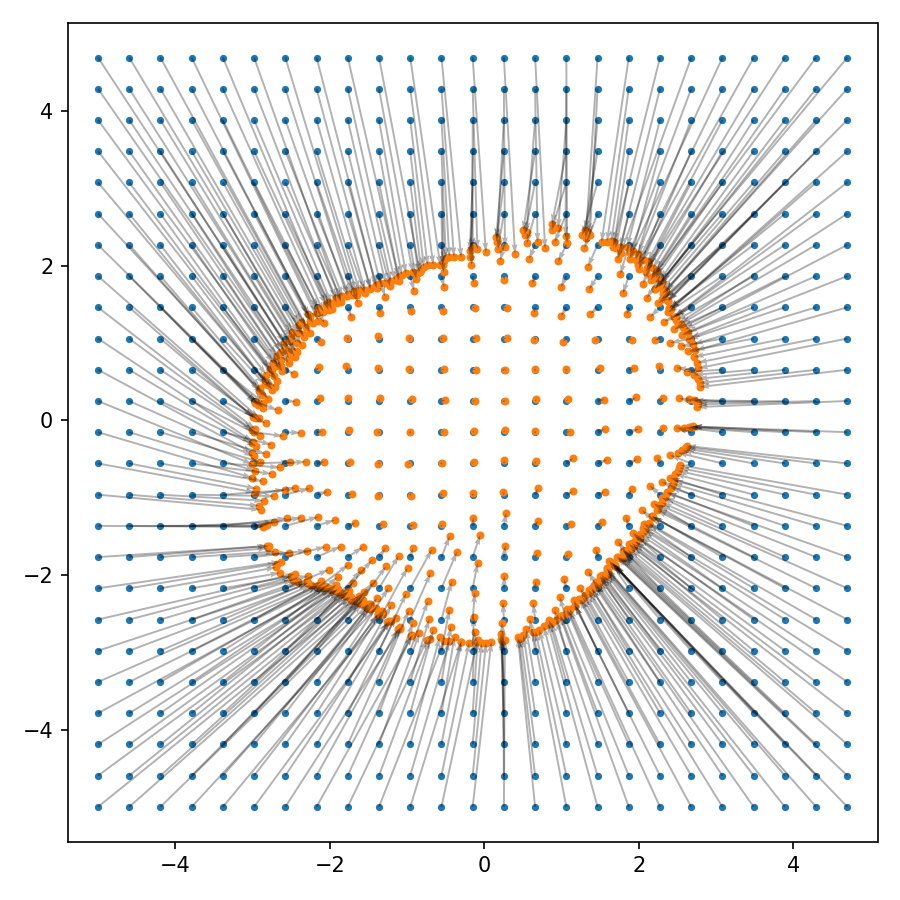

In [42]:
stepn = 4
s = starts[::stepn,::stepn,].reshape(-1,2)
e = ends[::stepn,::stepn].reshape(-1,2)
d = gradmap[::stepn,::stepn].reshape(-1,2)

plt.figure(figsize=(6,6))
plt.scatter(*s.t(), s=6)
plt.scatter(*e.t(), s=8)
plt.quiver(*s.t(), *d.view(-1,2).t(), angles='xy', scale_units='xy', scale=1, lw=0.2, alpha=0.3)
plt.xlim(starts[...,0].min()*1.1, starts[...,0].max()*1.1)
plt.ylim(starts[...,1].min()*1.1, starts[...,1].max()*1.1)
plt.axis('equal')
plt.tight_layout();

<IPython.core.display.Javascript object>


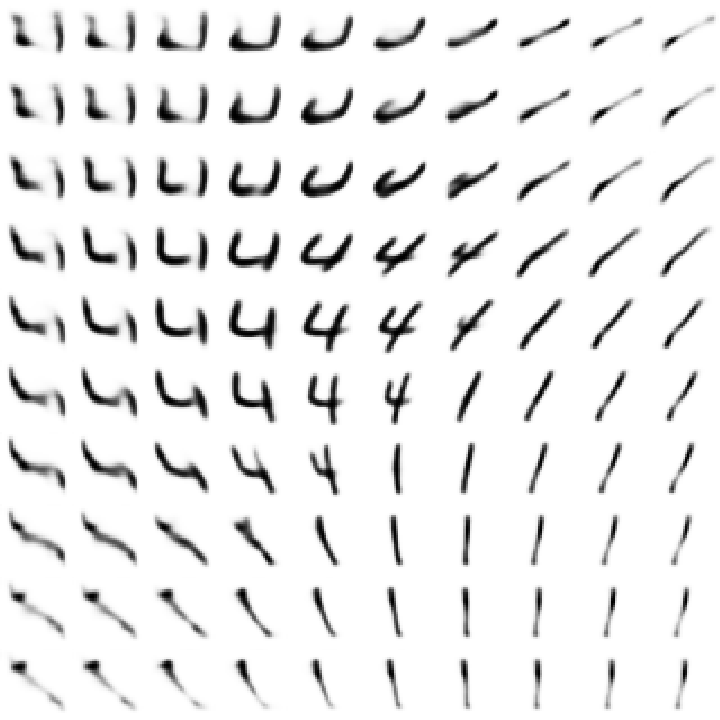

In [43]:
n_obs = 10

interp_idx = bidx+2

vin = Q[interp_idx:interp_idx+1].expand(n_obs**2, -1).contiguous()
vin[:,dims] = torch.stack(torch.meshgrid(torch.linspace(mn[ix].item(),mx[ix].item(),n_obs), torch.linspace(mn[iy].item(),mx[iy].item(),n_obs)),-1).reshape(-1,2)
with torch.no_grad():
    intmap = decode(vin).cpu()
imshape = intmap.shape[1:]
intmap = torch.from_numpy(intmap.reshape(n_obs,n_obs,*imshape).permute(1,0,2,3,4).numpy()[::-1].copy()).reshape(n_obs*n_obs,*imshape)
# intmap = intmap.reshape(n_obs,n_obs)
util.plot_imgs(intmap, H=n_obs, params=dict(cmap='Greys'));

<IPython.core.display.Javascript object>


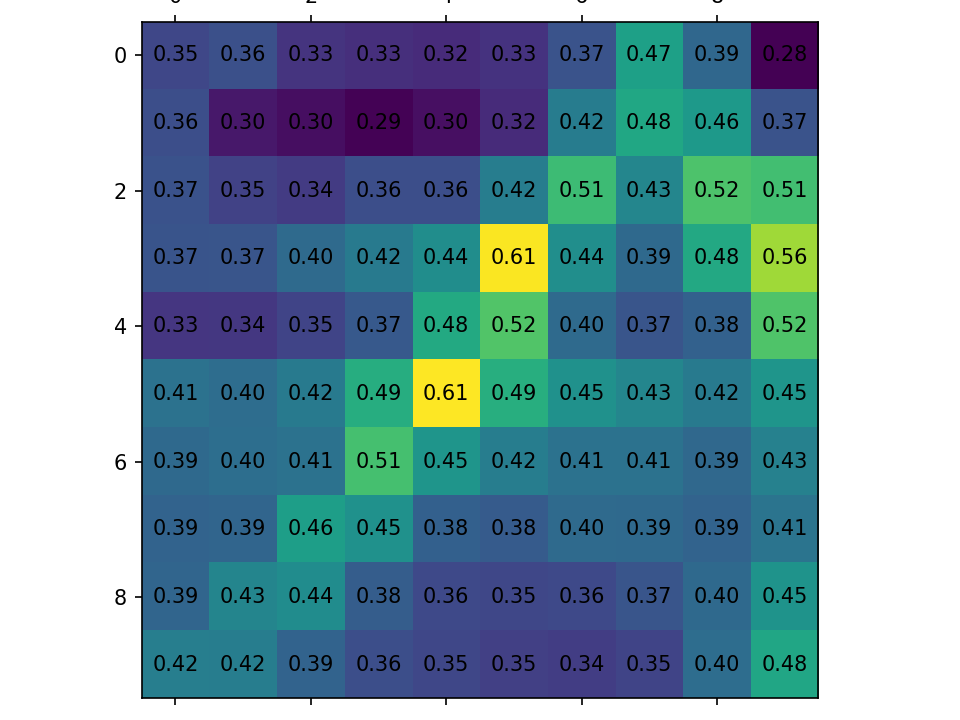

In [40]:
def div_score(q, n_noise=64, noise_mag=None, max_batch_size=64):
    if noise_mag is None:
        noise_mag = min(1/n_noise, 0.2)
    
    D = q.size(-1)
    q = q.reshape(-1, D)
    B = q.size(0)
    
    
    q = q.unsqueeze(1)
    
    noise = F.normalize(torch.randn(1, n_noise, D), p=2, dim=-1)
    
    resp = util.process_in_batches(intervention_response_function, q.expand(-1,n_noise,-1).reshape(-1,D), noise.mul(noise_mag).expand(B,-1,-1).reshape(-1,D), batch_size=max_batch_size)
    return noise.expand(B,-1,-1).reshape(-1,1,D).bmm(resp.unsqueeze(-1)).reshape(B,n_noise).mean(-1).div(noise_mag)
dsc = div_score(vin,n_noise=64,noise_mag=.01).reshape(n_obs,n_obs)
util.plot_mat(dsc.t().numpy()[::-1], val_fmt=2);

<IPython.core.display.Javascript object>


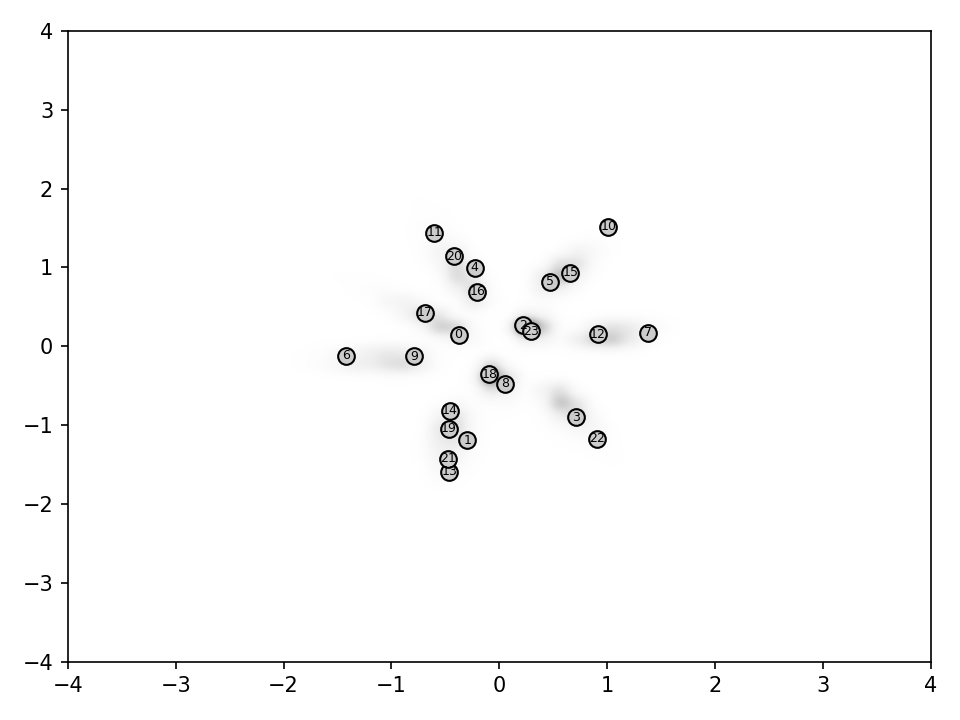

In [72]:
plt.figure()
ax_lat_path = plt.gca()
plt.imshow(hist.T[::-1], cmap='Greys', interpolation = "gaussian", **im_kwargs)
# plt.imshow(curvmap.numpy().T[::-1], cmap='viridis', **im_kwargs);

n_cts = 24

cts = torch.from_numpy(KMeans(n_clusters=n_cts, random_state=10).fit(Qsel.numpy()).cluster_centers_)
xinds = torch.searchsorted(xvals, cts[:,0].contiguous())
yinds = torch.searchsorted(yvals, cts[:,1].contiguous())
cinds = torch.stack([xinds,yinds],-1)
cinds = [tuple(c) for c in cinds.tolist()]

for k, q in enumerate(cts):
    plt.plot(*q, 'o', markerfacecolor='0.8',
             markeredgecolor='k', markersize=8)
    plt.text(*q, str(k), ha='center', va='center', fontsize=6)
plt.xlim(xvals.min(),xvals.max(),)
plt.ylim(yvals.min(),yvals.max());
plt.tight_layout();

In [45]:
path_cts = [
#     [0,17],
]
all_paths = []
all_costs = []

path_locs = [
    [(1,-1), (-2,0)]
]

temp = 1./2

In [46]:
landscape = magmap.clone()**(1/temp)
posteriormap = curvmap.clone()
landscape.shape

torch.Size([64, 64])

In [47]:
DMAP = nx.grid_2d_graph(*magmap.shape)
# def _cost(u,v,*other):
# #     print(u,v,other)
# #     dr = torch.tensor([v[0]-u[0], v[1]-u[1]]).float().cpu()
# #     return (dr @ deltas[u]).item()
#     return mags[v]
def _find_route(p1,p2):
    x1idx, x2idx = torch.searchsorted(xvals, torch.tensor([p1[0],p2[0]]).float()).tolist()
    y1idx, y2idx = torch.searchsorted(xvals, torch.tensor([p1[1],p2[1]]).float()).tolist()
    u,v = (x1idx,y1idx), (x2idx,y2idx)
    L, ph = nx.algorithms.shortest_paths.weighted.single_source_dijkstra(DMAP, u,v, weight=lambda u,v,_o: landscape[v].item())
    return L, (u,v), ph

path_locs.extend([(cts[i],cts[j]) for i,j in path_cts])

for s,e in path_locs:
    cost, _, path = _find_route(s,e)

    xlp, ylp = zip(*path)
    xlp, ylp = xvals[list(xlp)], yvals[list(ylp)]
    Qpath = torch.stack([xlp, ylp],-1)
    all_costs.append(cost)
    all_paths.append(Qpath)
# plt.plot(xlp, ylp, c='m');
# cost, len(path)
plt.sca(ax_lat_path)
for i, (path, cost) in enumerate(zip(all_paths, all_costs)):
    plt.plot(*path.t(), c=f'C{i}',label=f'{cost:.3g}')
plt.legend(title='Costs');

all_costs

[0.8979962896801226]

In [48]:
show_mov = False
show_interp = np.random.randint(len(all_paths))
show_interp

0

In [49]:
def _show_interp(frames, vid=True):
    if vid:
        plt.ioff()
        if frames.shape[1] == 1:
            frames = frames.expand(-1,3,-1,-1)
        mov = util.Video(frames.permute(0,2,3,1).cpu())
        if figure_dir is not None:
            path = figure_dir / f'seq{bidx}.mp4'
        #     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
            mov.export(path)
            print(f'Movie saved: {str(path)}')
        out = mov.play('jupyter', scale=4)
        plt.ion()
    else:
        hval = 1
        util.plot_imgs(frames, W=len(interp), figsize=(len(interp)*hval,hval));
        s = 0.01
        plt.subplots_adjust(bottom=0.+s, top=1.-s, left=0.+s, right=1.-s, wspace=s, hspace=s)
        out = None
    return out

In [50]:
show_vid = True
nframes = 60 if show_vid else 7

bidx = 20

xlp, ylp = all_paths[show_interp].t()

xvp, yvp = torch.linspace(xlp[0],xlp[-1],nframes), torch.linspace(ylp[0],ylp[-1],nframes)
vecs = Q[bidx:bidx+1].expand(len(xvp), -1).contiguous()
vecs[...,dims[0]] = xvp
vecs[...,dims[1]] = yvp

binterp = decode(vecs)

xpin, ypin = torch.linspace(0,len(xlp)-1,nframes).long(), torch.linspace(0,len(ylp)-1,nframes).long()
xvp, yvp = xlp[xpin], ylp[ypin]
vecs = Q[bidx:bidx+1].expand(len(xvp), -1).contiguous()
vecs[...,dims[0]] = xvp
vecs[...,dims[1]] = yvp

interp = decode(vecs)
display(_show_interp(binterp, vid=show_vid))
display(_show_interp(interp, vid=show_vid))

In [65]:
fid_dim = 2048
true_mu, true_std = dataset.get_fid_stats(fid_dim, 'train')
true_mu, true_std = torch.from_numpy(true_mu), torch.from_numpy(true_std)
inception = learn.eval.fid.load_inception_model(fid_dim)
dr = distrib.MultivariateNormal(true_mu, true_std)
def _score(samples):
    feats = learn.eval.fid.apply_inception(samples, inception).squeeze().cpu()
    return dr.log_prob(feats)
# true_mu.shape, true_std.shape

In [66]:
_score(binterp).mean()

tensor(1678.2527, dtype=torch.float64)

In [69]:
inc_scors = _score(interp)
inc_scors.mean()

tensor(1678.0742, dtype=torch.float64)

In [144]:
Q.shape, fullQ.shape

(torch.Size([64, 12]), torch.Size([10000, 12]))

In [132]:
# def div_score(q, n_noise=64, noise_mag=None, max_batch_size=64):
#     if noise_mag is None:
#         noise_mag = min(1/n_noise, 0.2)
    
#     D = q.size(-1)
#     q = q.reshape(-1, D)
#     B = q.size(0)
    
    
#     q = q.unsqueeze(1)
    
#     noise = F.normalize(torch.randn(1, n_noise, D), p=2, dim=-1)
    
#     resp = util.process_in_batches(intervention_response_function, q.expand(-1,n_noise,-1).reshape(-1,D), noise.mul(noise_mag).expand(B,-1,-1).reshape(-1,D), batch_size=max_batch_size)
#     return noise.expand(B,-1,-1).reshape(-1,1,D).bmm(resp.unsqueeze(-1)).reshape(B,n_noise).mean(-1).div(noise_mag)
    
    
# #     noise = torch.randn(1,n_noise,D).mul(noise_mag)
#     noise = F.normalize(torch.randn(1, n_noise, D), p=2, dim=-1).mul(noise_mag)
#     rq = util.process_in_batches(response_function, q, batch_size=max_batch_size).unsqueeze(1)
#     rdq = util.process_in_batches(response_function, q.unsqueeze(1).add(noise).reshape(-1,D), batch_size=max_batch_size).reshape(B,n_noise,D)
#     return rdq.sub(rq).div(noise).sum(-1).mean(-1)
    
#     resp = util.process_in_batches(response_function, q.add(noise.mul(noise_mag)).reshape(-1,D), batch_size=max_batch_size)
#     return noise.expand(B,-1,-1).reshape(-1,1,D).bmm(resp.unsqueeze(-1)).reshape(B,n_noise).sum(-1)




# def _gen_good(N, n_noise=64, noise_mag=None):
#     if noise_mag is None:
#         noise_mag = min(1/n_noise, 0.2)
    
#     accepted = []
    
#     noise = F.normalize(torch.randn(n_noise,D),p=2)
    
#     while len(accepted) < N:
#         base = model.sample_prior().view(1, -1)
#         q = base + noise_mag*noise
        
#         with torch.no_grad():
#             resp = ae_cycle(q)[1] - q
        
#         return resp.unsqueeze(1).bmm(noise.unsqueeze(-1)).sum()
        
        
    

In [70]:
sc = div_score(vecs, n_noise=32, noise_mag=0.01)
sc.shape
# util.plot_imgs(decode(q), 
#                #W=num, 
# #                figsize=(num,1), 
#                titles=[f'{s:.2g}' for s in sc.tolist()], 
#                params=dict(cmap='Greys',interpolation='gaussian'));

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


torch.Size([60])

<IPython.core.display.Javascript object>


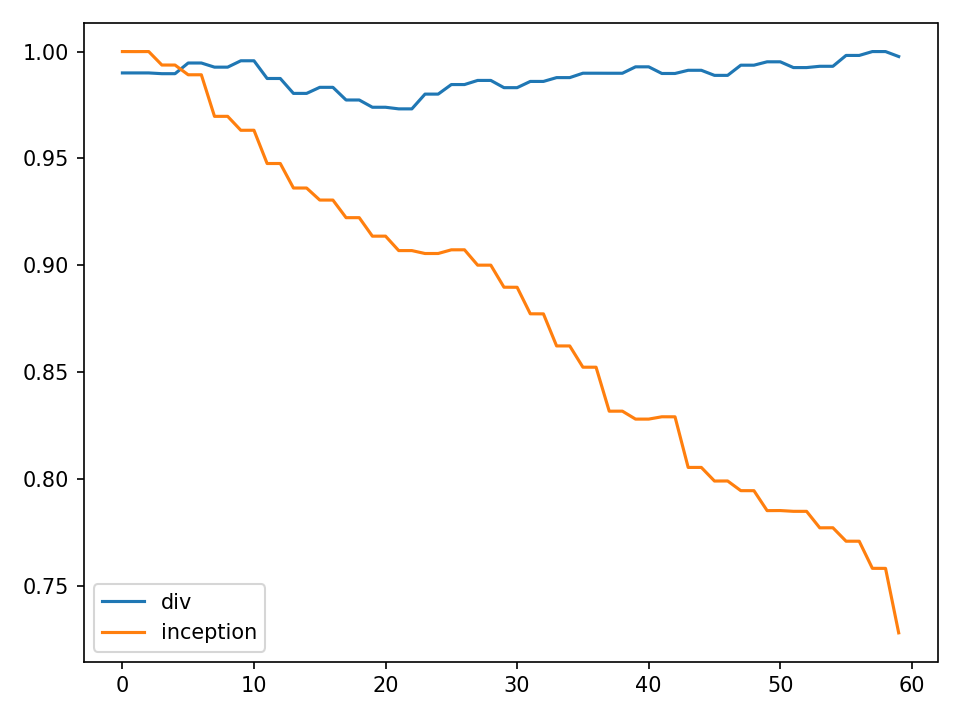

In [72]:
plt.figure()
plt.plot(sc/max(sc), label='div')
plt.plot(inc_scors/max(inc_scors), label='inception')
plt.legend();
plt.tight_layout();

<IPython.core.display.Javascript object>


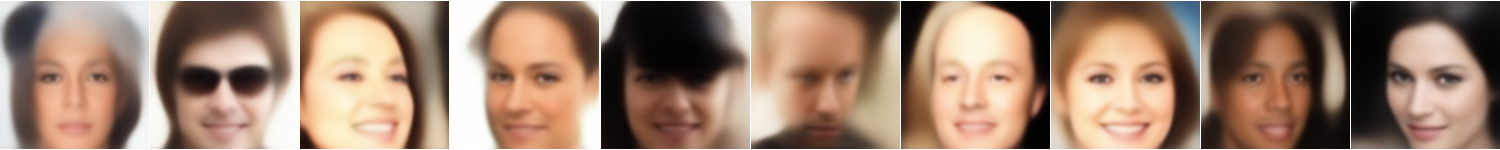

In [54]:
num = 10
q = model.sample_prior(num).cpu()
util.plot_imgs(decode(q), W=num, figsize=(num,1), params=dict(cmap='Greys',interpolation='gaussian'));

<IPython.core.display.Javascript object>


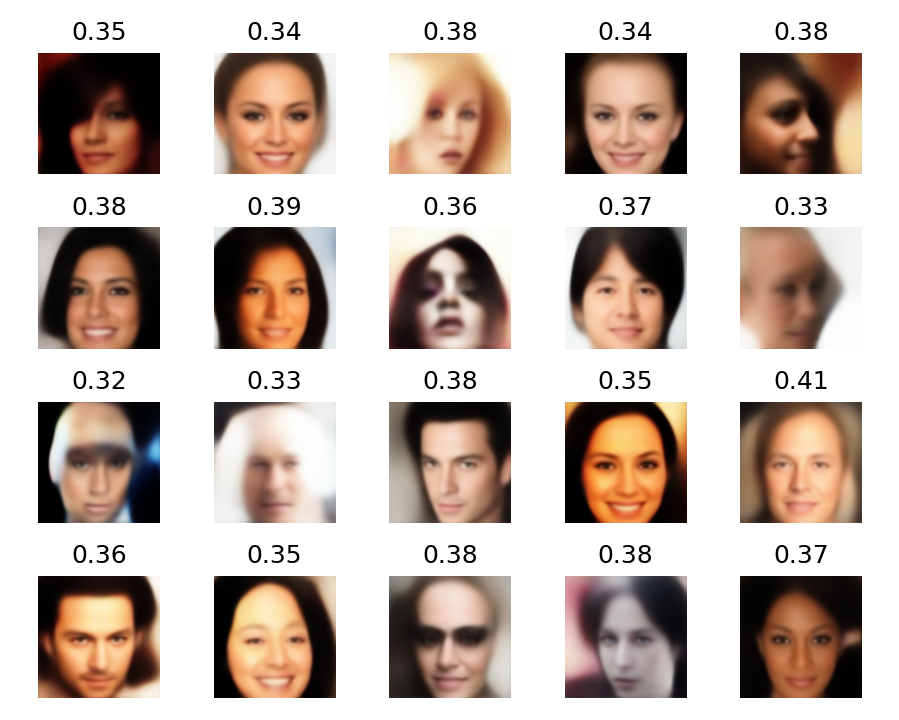

In [55]:
num = 20
q = model.sample_prior(num).cpu()
sc = div_score(q, n_noise=32, noise_mag=0.01)
util.plot_imgs(decode(q), 
               #W=num, 
#                figsize=(num,1), 
               titles=[f'{s:.2g}' for s in sc.tolist()], 
               params=dict(cmap='Greys',interpolation='gaussian'));

In [27]:
fid_dim = 2048
true_mu, true_std = dataset.get_fid_stats(fid_dim, 'train')
true_mu, true_std = torch.from_numpy(true_mu), torch.from_numpy(true_std)
inception = learn.eval.fid.load_inception_model(fid_dim)

In [44]:
learn.eval.fid.compute_inception_stat

<module 'omnilearn.eval.fid' from 'c:\\users\\anwan\\onedrive\\khan\\research\\foundation\\omnilearn\\eval\\fid\\__init__.py'>

In [28]:
def make_gen_by_mag(mn, mx):
    def gen_fn(N):
        with torch.no_grad():
            q = F.normalize(model.sample_prior(N), p=2, dim=-1).mul(torch.rand(N,1,device=model.device).mul(mx-mn).add(mn))
            return model.decode(q)
    return gen_fn

In [51]:
m,s = learn.eval.fid.compute_inception_stat(make_gen_by_mag(0.,0.5), inception=inception, n_samples=100, pbar=tqdm)
m.shape, s.shape

  0%|          | 0/100 [00:00<?, ?it/s]

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


((2048,), (2048, 2048))

In [29]:
# fullR = util.process_in_batches(response_function, fullQ, batch_size=64)
# fullR.shape
# util.MMD(fullQ.cpu(), fullR.cpu())

torch.Size([10000, 12])

In [26]:
prior = model.sample_prior(1000)
rprior = util.process_in_batches(response_function, prior, batch_size=64)
rprior.shape, prior.shape

(torch.Size([1000, 12]), torch.Size([1000, 12]))

In [27]:
util.MMD(prior.cpu(), rprior.cpu())

tensor(0.0173)

In [32]:
util.MMD(prior.cpu(), rprior.cpu())

tensor(0.0492)

tensor(0.0002)

In [54]:
q.shape

torch.Size([20, 12])

In [55]:
B, D = q.shape

In [56]:
noise_mag = 0.05
n_noise = 16
max_batch_size = 64

In [57]:
noise = torch.randn(1,n_noise,D).mul(noise_mag)#.expand(B,-1,-1).reshape(-1,D)
# qq = q.reshape(-1, 1, D).expand(-1,n_noise,-1).reshape(-1,D)
noise.shape#, qq.shape

torch.Size([1, 16, 12])

In [58]:
rq = util.process_in_batches(response_function, q, batch_size=max_batch_size).unsqueeze(1)
rdq = util.process_in_batches(response_function, q.unsqueeze(1).add(noise).reshape(-1,D), batch_size=max_batch_size).reshape(B,n_noise,D)
rq.shape, rdq.shape

(torch.Size([20, 1, 12]), torch.Size([20, 16, 12]))

In [59]:
div = rdq.sub(rq).div(noise).sum(-1).mean(-1)
div

tensor([ -2.9573,   4.1824,   0.1392,   1.4028, -11.6802, -41.4903, -10.2423,
         -7.3582,  39.4358,   1.6105, -19.0608,   4.6345,  -5.0558, -22.0451,
        -14.7435,  -6.7415, -17.1673, -11.1649, -12.1096,  -0.9725])

In [231]:
dR.shape

torch.Size([10, 16, 12])

In [232]:
noise = F.normalize(torch.randn(1, n_noise, D), p=2, dim=-1)
noise.shape

torch.Size([1, 16, 12])

In [233]:
qq = q.reshape(-1, 1, D).expand(-1,n_noise,-1).reshape(-1,D)
qq.shape

torch.Size([320, 12])

In [173]:
nn = noise.mul(noise_mag).expand(B,-1,-1).reshape(-1,D)
nn.shape

torch.Size([40, 12])

In [ ]:
util.process_in_batches(intervention_response_function

In [ ]:
resp = util.process_in_batches(intervention_response_function, q.expand(-1,n_noise,-1).reshape(-1,D), noise.mul(noise_mag).expand(B,-1,-1).reshape(-1,D), batch_size=max_batch_size)

Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


<IPython.core.display.Javascript object>


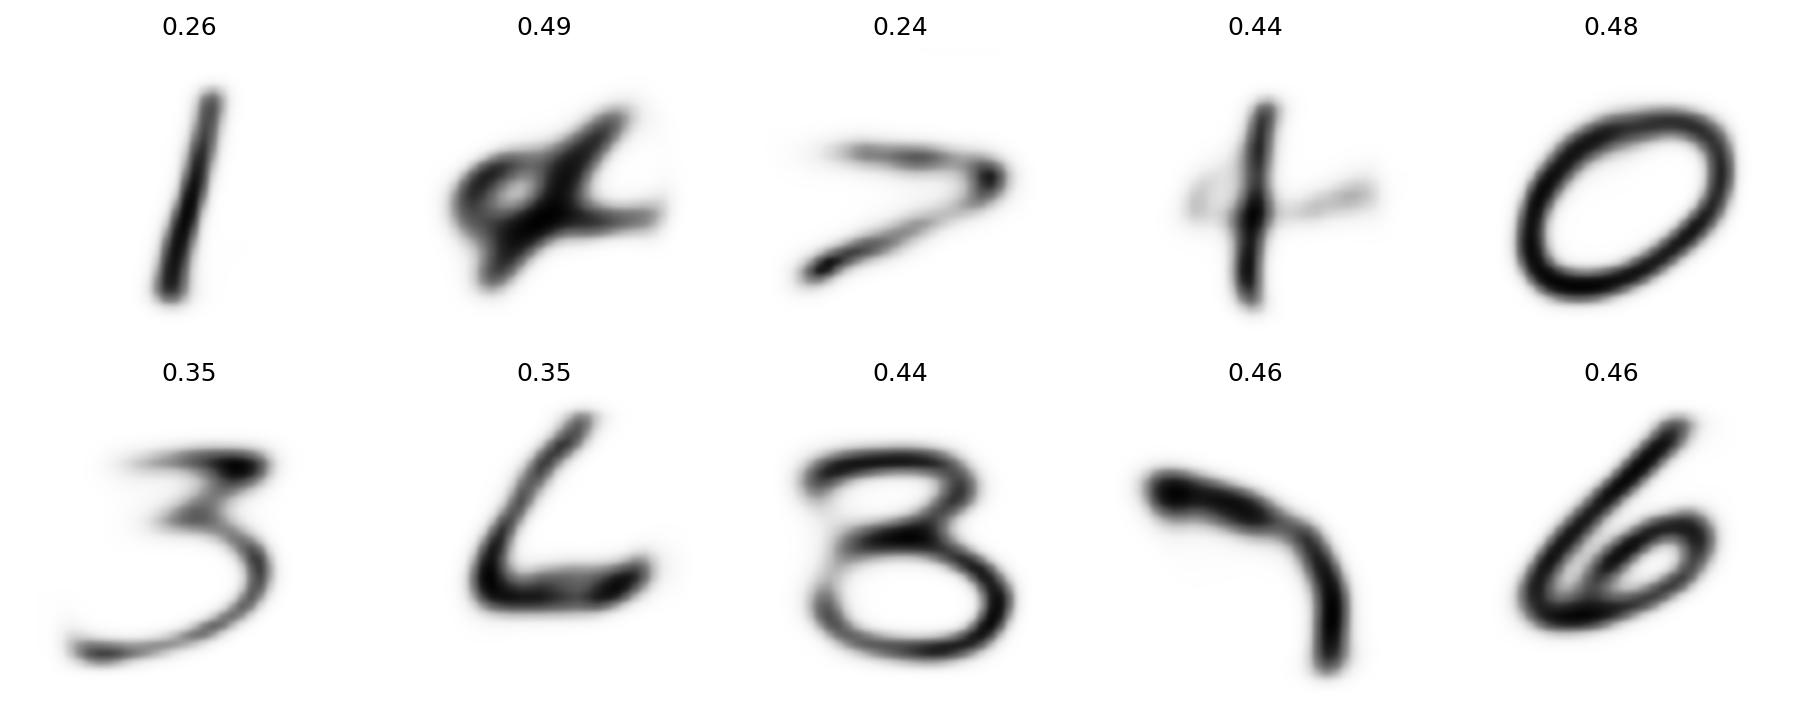

<IPython.core.display.Javascript object>


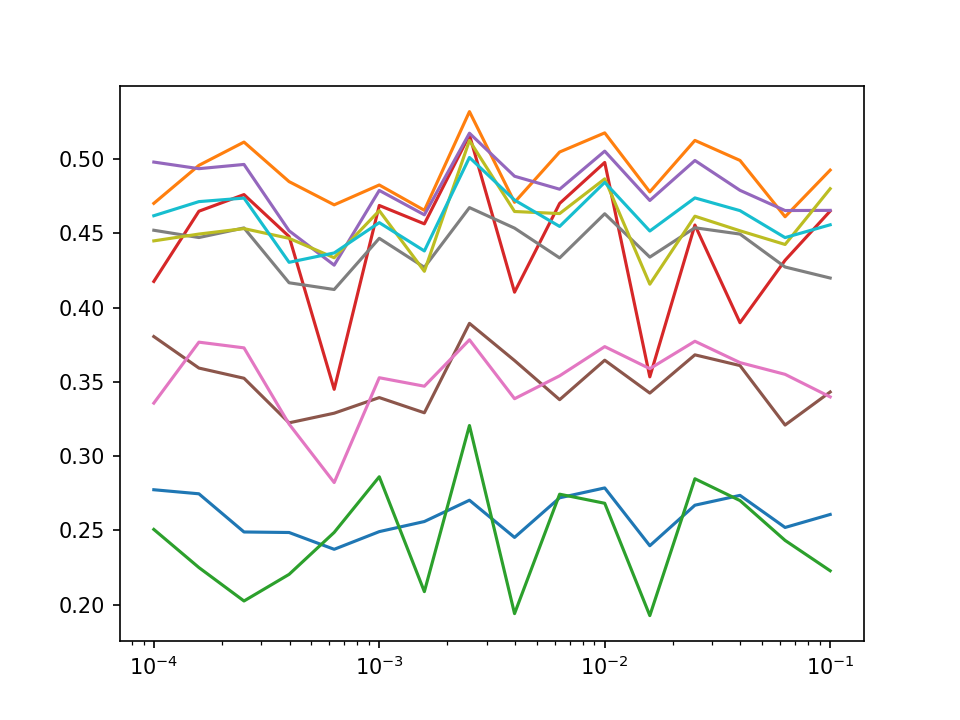

In [67]:
# q = model.sample_prior(10).cpu()
mags = torch.logspace(-4,-1,16)
scores = torch.stack([div_score(q, n_noise=128, noise_mag=m) for m in mags])

sc = div_score(q, n_noise=32, noise_mag=0.01)
util.plot_imgs(decode(q), 
               #W=num, 
#                figsize=(num,1), 
               titles=[f'{s:.2g}' for s in scores.mean(0).tolist()], 
               params=dict(cmap='Greys',interpolation='gaussian'));

plt.figure() 
plt.xscale('log')
plt.plot(mags,scores);

In [170]:
ne = 32
emag = 1/ne

In [171]:
noise = F.normalize(torch.randn(32,Q.shape[-1]),p=2) * emag

In [172]:
base = model.sample_prior().cpu()
q = base + noise

In [173]:
with torch.no_grad():
    resp = ae_cycle(q)[1] - q
resp.shape

torch.Size([32, 12])

In [174]:
dt = noise.unsqueeze(1).bmm(resp.unsqueeze(-1))
dt.sum()

tensor(-0.0244)

In [169]:
del resp

In [103]:
mats, lts = factor_reponses(encode, decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [167]:
del base, noise, dt

<IPython.core.display.Javascript object>


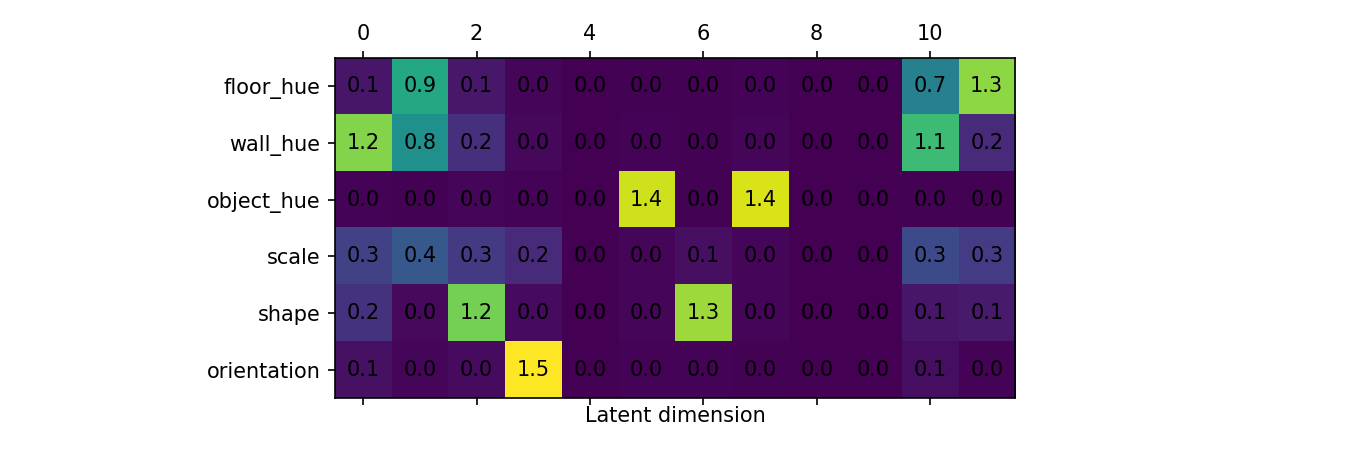

In [104]:
M_old = mats.min(1)[0].max(-1)[0]
M = mats.min(1)[0].diagonal(0,-1,-2)
M = mats.mean(1).diagonal(0,-1,-2)
# M = mats.max(1)[0].diagonal(0,-1,-2)
# M = mats.mean(1).max(-1)[0]

# mats.shape, len(lts), M.shape

util.plot_mat(M, val_fmt=1, figsize=(9,3))
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
# util.save_figure(f'factor-responses', root=figure_dir);

In [541]:
n = 16
steps = 40
# info.steps = 20
# info.steps = 7
# info.steps = 5
ntrav = 1

In [542]:
q = Q[bidx]

tH, tW = 4,3
if info is None:
    tH, tW = 5, 2
else:
    if info['dec_type'] == 's6':
        tH, tW = 6,2
    if info['dec_type'] == 's3':
        tH, tW = 3,4

vecs = viz_util.get_traversal_vecs(q.unsqueeze(0), steps=steps,
      mnmx=(mn,mx)).contiguous()
# deltas = torch.diagonal(vecs, dim1=-3, dim2=-1)
# vecs.shape
walks = viz_util.get_traversals(vecs, model.decode, device=device).cpu()
# diffs = viz_util.compute_diffs(walks)
walks.shape
    
if walks.size(1) != tH*tW:
    tH, tW = util.calc_tiling(walks.size(1))
    
tH, tW

(4, 3)

In [543]:
full = walks

# tH, tW = util.calc_tiling(full.size(1), prefer_tall=True)
B, N, S, C, H, W = full.shape


full = full.view(B, tH, tW, S, C, H, W)
# print(full.shape)
full = full.squeeze(0).permute(2,0,4,1,5,3).contiguous()
frames = full.view(S, tH*H, tW*W, C).mul(255).byte().numpy()



frames.shape
# full = full.permute(0,1,2,5,3,6,4).contiguous().view(B, run.tH, run.tW*H, S*W, C).squeeze(0)

(40, 256, 192, 3)

In [544]:

font                   = cv2.FONT_HERSHEY_SIMPLEX
font                   = cv2.FONT_HERSHEY_COMPLEX
fontScale              = 0.5
fontColor              = (0,0,0)
lineType               = 1

px, py = 2, 12

for frame in frames:
    for i,j in np.ndindex(tH, tW):
        idx = i*tW+j
        cv2.putText(frame, f'{idx}', 
            (px+H*j, py+W*i), 
            font, 
            fontScale,
            fontColor,
            lineType)


In [545]:
mov = util.Video(frames)
if figure_dir is not None:
    path = figure_dir / f'seq{bidx}.mp4'
#     path = figure_dir / f'{run.name}_seq{bidx}.mp4'
    mov.export(path)
    print(f'Movie saved: {str(path)}')
plt.ioff()
out = mov.play('jupyter', scale=2)
plt.ion()
out

<IPython.core.display.Javascript object>


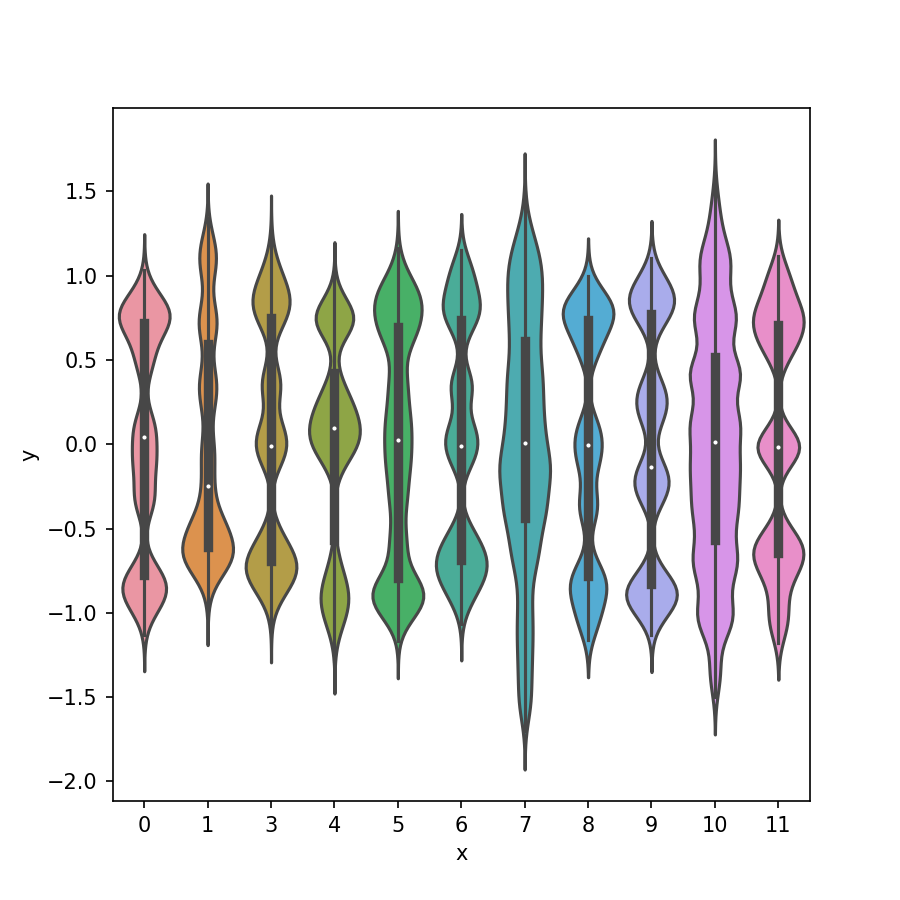

In [546]:
util.plot_distribs(fullQ.t()[sel].cpu());
plt.xticks(np.arange(len(sel)),sel.tolist());
util.save_figure(f'latent_marginals', root=figure_dir);

<IPython.core.display.Javascript object>


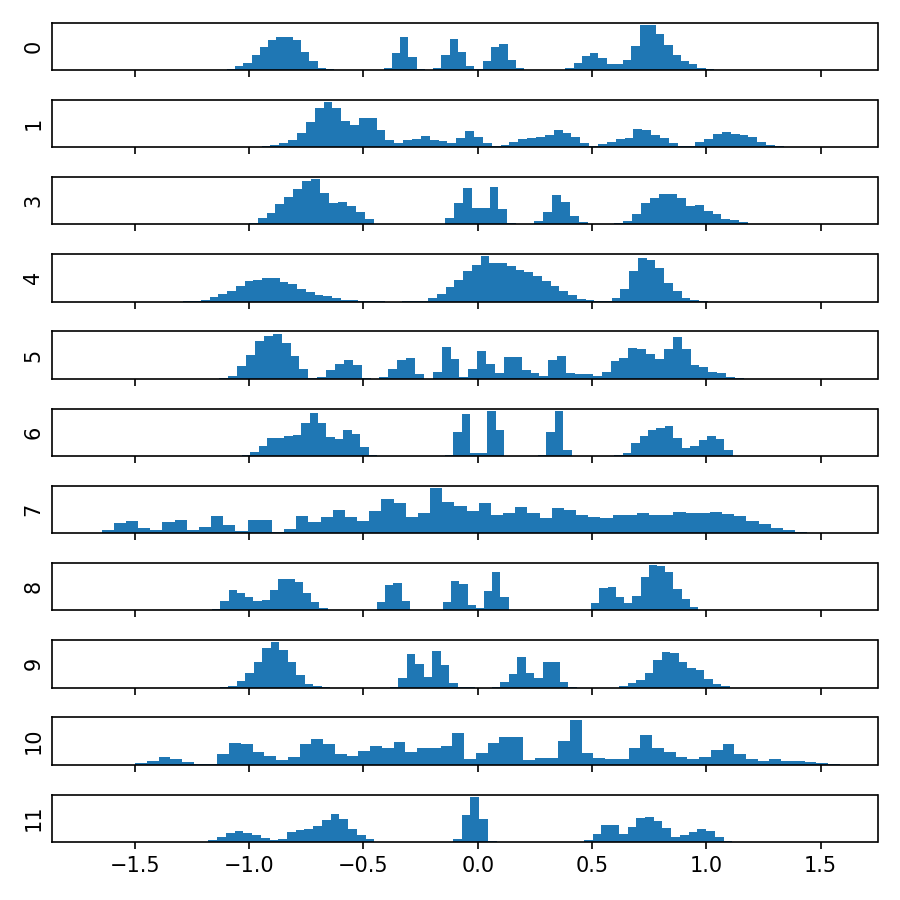

In [547]:
pts = fullQ.cpu().t()[sel]
fg, axs = util.plot_hists(pts, bins=60, sharex=True);
for ax, s in zip(axs, sel.tolist()):
    plt.sca(ax)
    plt.ylabel(str(s))
#     plt.xticks([])
    plt.yticks([])
plt.tight_layout()
util.save_figure(f'latent_hists', root=figure_dir);